## Parametrization

In [1]:
# remember to run nbdev_build_lib first! 

# !nbdev_build_lib
# import compmemlearn
# import importlib
# import repetition_cmr
# importlib.reload(repetition_cmr.analyses)
# from repetition_cmr.analyses import recall_probability_by_lag, spc, lag_crp, repetition_contiguity

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.model_analysis import matrix_heatmap, icmr_memory_heatmap 
from compmemlearn.model_analysis import connectivity_by_lag, mfc_heatmap
from compmemlearn.analyses import flex_mixed_pfr
from compmemlearn.fitting import generate_objective_function, apply_and_concatenate
from compmemlearn.datasets import simulate_df, simulate_array_from_presentations, events_metadata
from repetition_cmr.model_evaluation import repetition_connectivity_by_lag, latent_mfc_mcf_mff, mixed_connectivity_by_lag
from repetition_cmr.analyses import recall_probability_by_lag, spc, lag_crp, repetition_contiguity
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
from numpy import matlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

section_tag = "InstanceCMR"

data_path = "../../data/LohnasKahana2014.csv"
trial_query = "condition == 4"

model_paths = ["compmemlearn.models.Instance_CMR"]

model_names = ["InstanceCMR"]

parameter_ranges = {
    #'feature_drift_rate': np.arange(.001, 1, .1),
    'context_sensitivity': np.arange(1.0, 10.0, 1),
    'mcf_familiarity_scale': np.arange(.001, 1, .1)
}

free_parameters = [ 
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #'choice_sensitivity',
            "context_sensitivity",
        #    "feature_sensitivity",
        "delay_drift_rate",
        "mcf_familiarity_scale"
    ]
]

bounds = [
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
        [lb, ub],
    ],
]

fixed_parameters = [
    {"choice_sensitivity": 1.0, "feature_sensitivity": 1.0, 'mfc_familiarity_scale': 0.0, 'drift_familiarity_scale': 0.0},
]

fit_result = [

]

benchmark_experiment_count = 100
parameter_shifting_experiment_count = 100

In [2]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

# load dataset and extract key metadata
events = pd.read_csv(data_path)
trials, list_length, presentations, trial_details = events_metadata(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
        events,
        trial_query,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))

24152.56176349077
75164.9055578603


## Fitting

In [3]:
#| code-summary: code -- 1) fit models to entire dataset
#| output: false

if len(fit_result) != len(models):
    for model_index, model_class in enumerate(models):

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        cost_function = generate_objective_function(
                events,
                trial_query,
                init_model,
                fixed_parameters[model_index],
                free_parameters[model_index],
            )

        fit_result.append(
            differential_evolution(
                cost_function, bounds[model_index], disp=True
            ))
        print(fit_result[-1])
        fit_result[-1] = fit_result[-1].x

differential_evolution step 1: f(x)= 19996.9
differential_evolution step 2: f(x)= 19996.9
differential_evolution step 3: f(x)= 19996.9
differential_evolution step 4: f(x)= 19996.9
differential_evolution step 5: f(x)= 19996.9
differential_evolution step 6: f(x)= 19785.1
differential_evolution step 7: f(x)= 19706.5
differential_evolution step 8: f(x)= 19695.7
differential_evolution step 9: f(x)= 19654.2
differential_evolution step 10: f(x)= 19622.9
differential_evolution step 11: f(x)= 19622.9
differential_evolution step 12: f(x)= 19622.5
differential_evolution step 13: f(x)= 19545.2
differential_evolution step 14: f(x)= 19538.9
differential_evolution step 15: f(x)= 19399.3
differential_evolution step 16: f(x)= 19121.5
differential_evolution step 17: f(x)= 18256.5
differential_evolution step 18: f(x)= 18256.5
differential_evolution step 19: f(x)= 18256.5
differential_evolution step 20: f(x)= 18256.5
differential_evolution step 21: f(x)= 18256.5
differential_evolution step 22: f(x)= 18256

## Memory Simulation

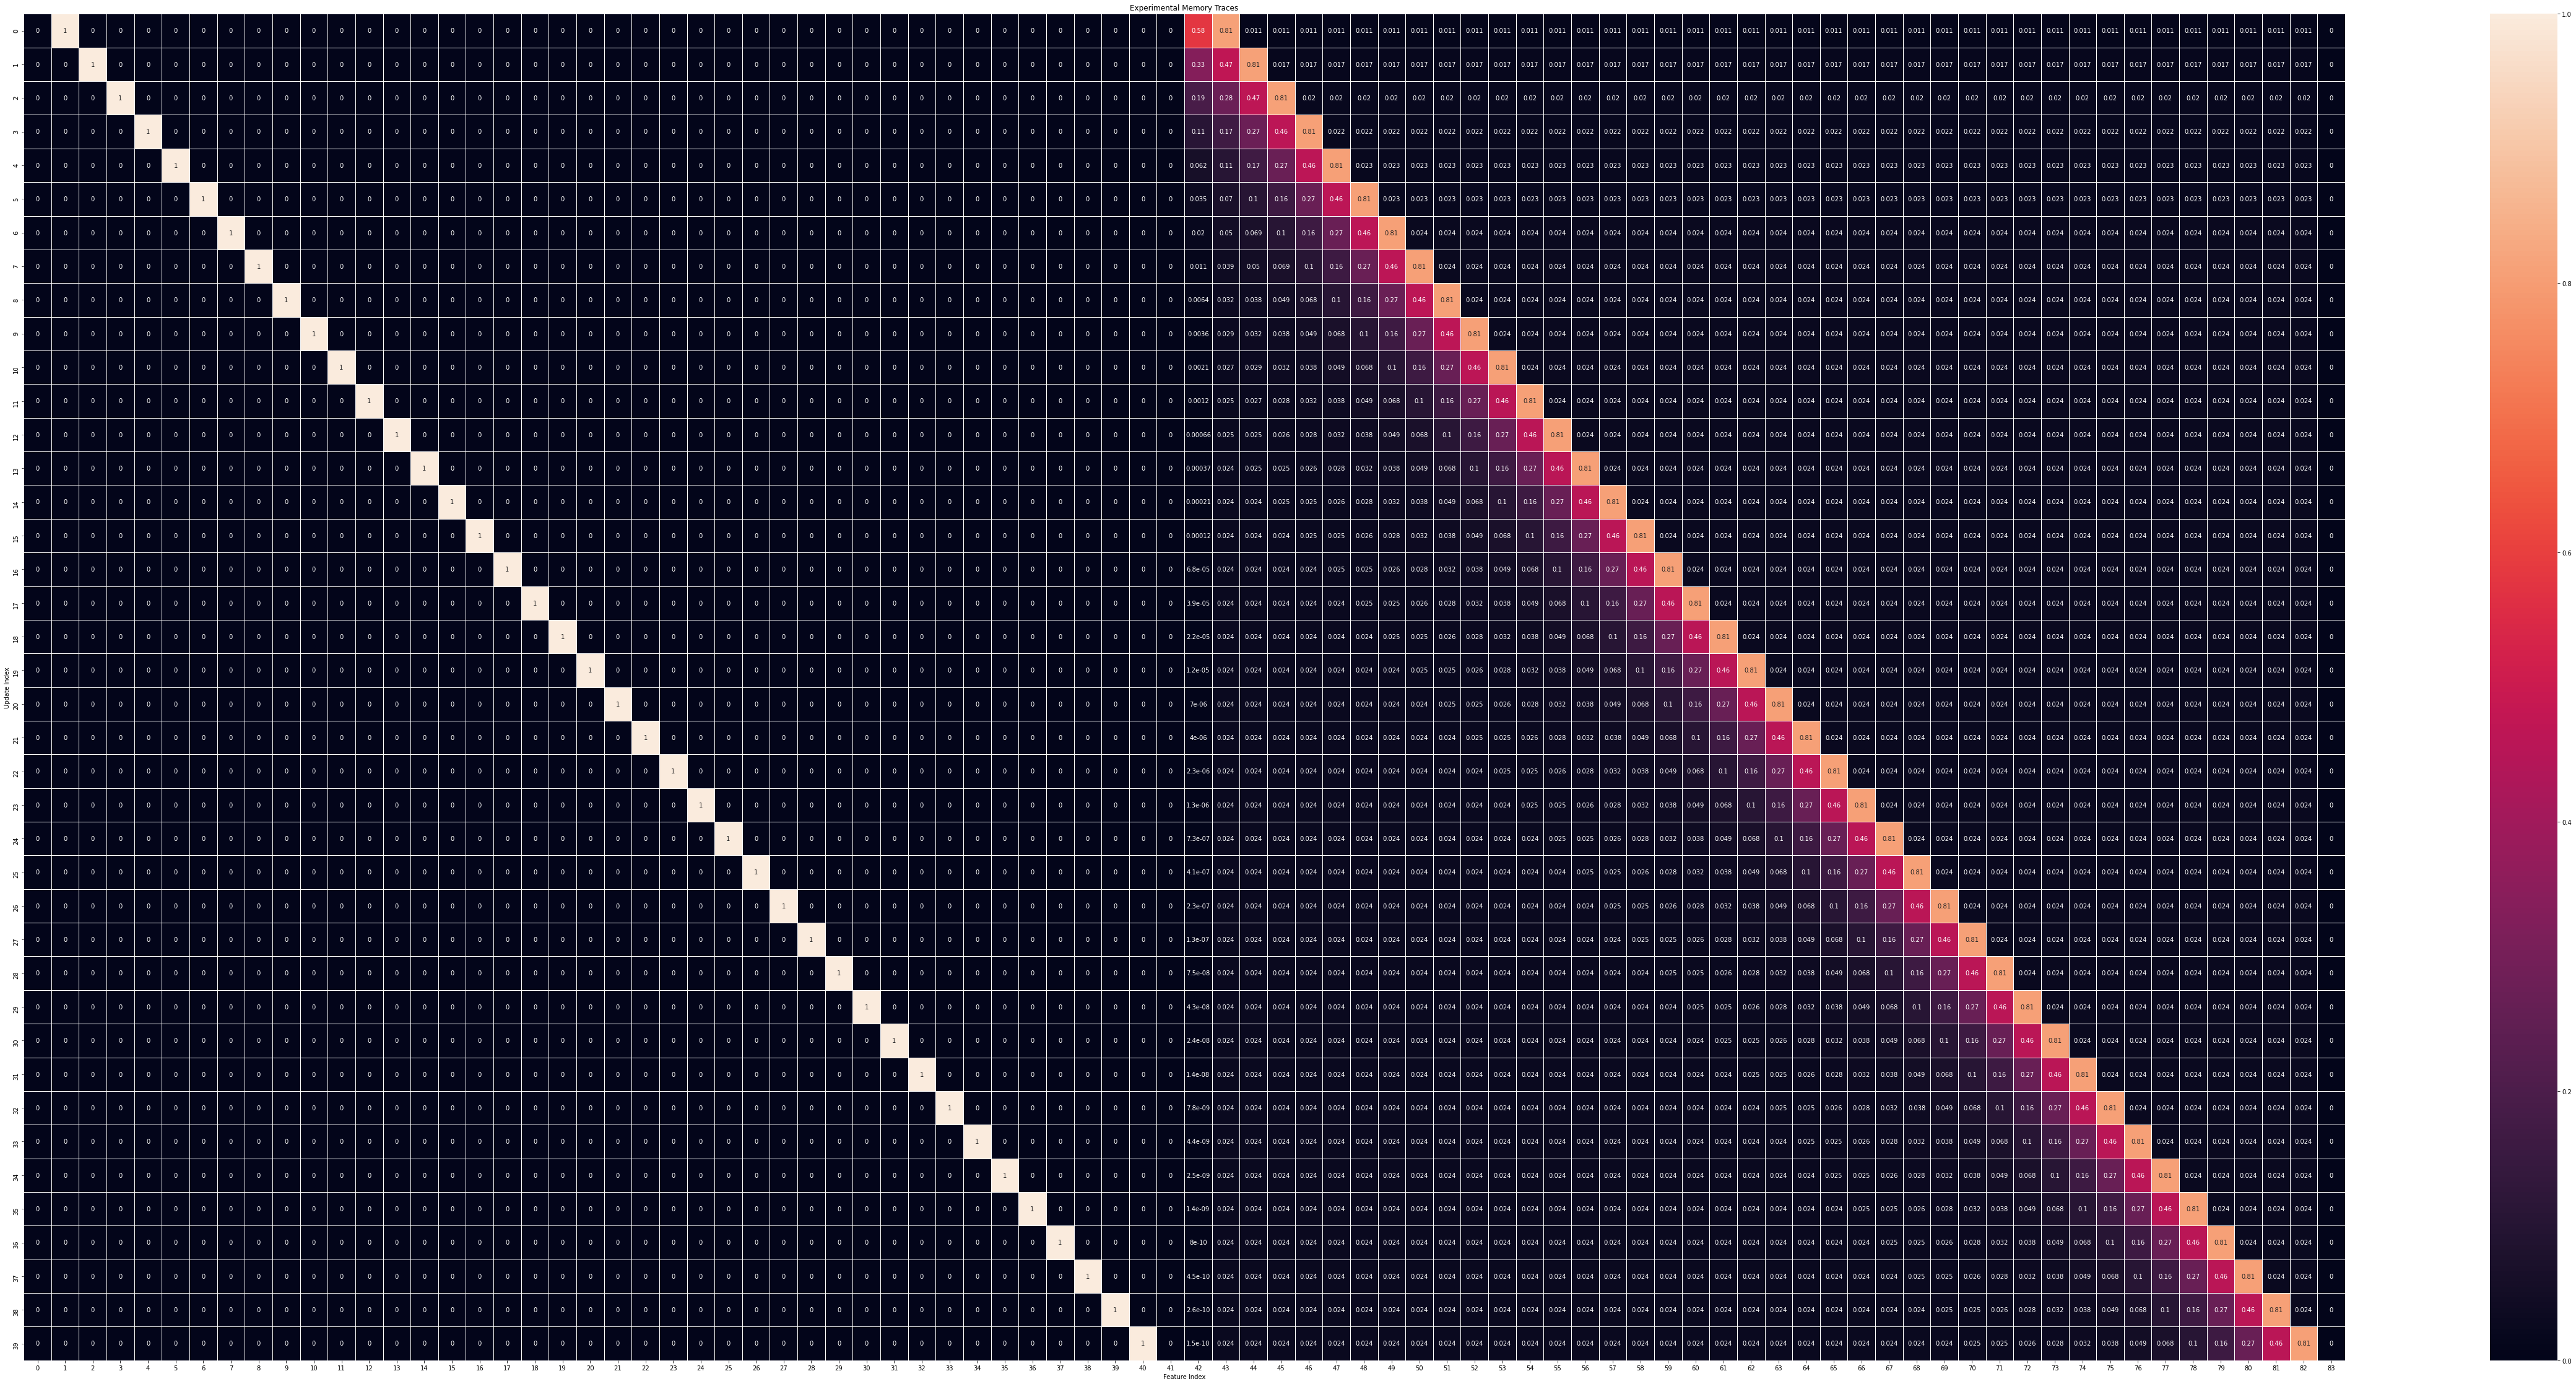

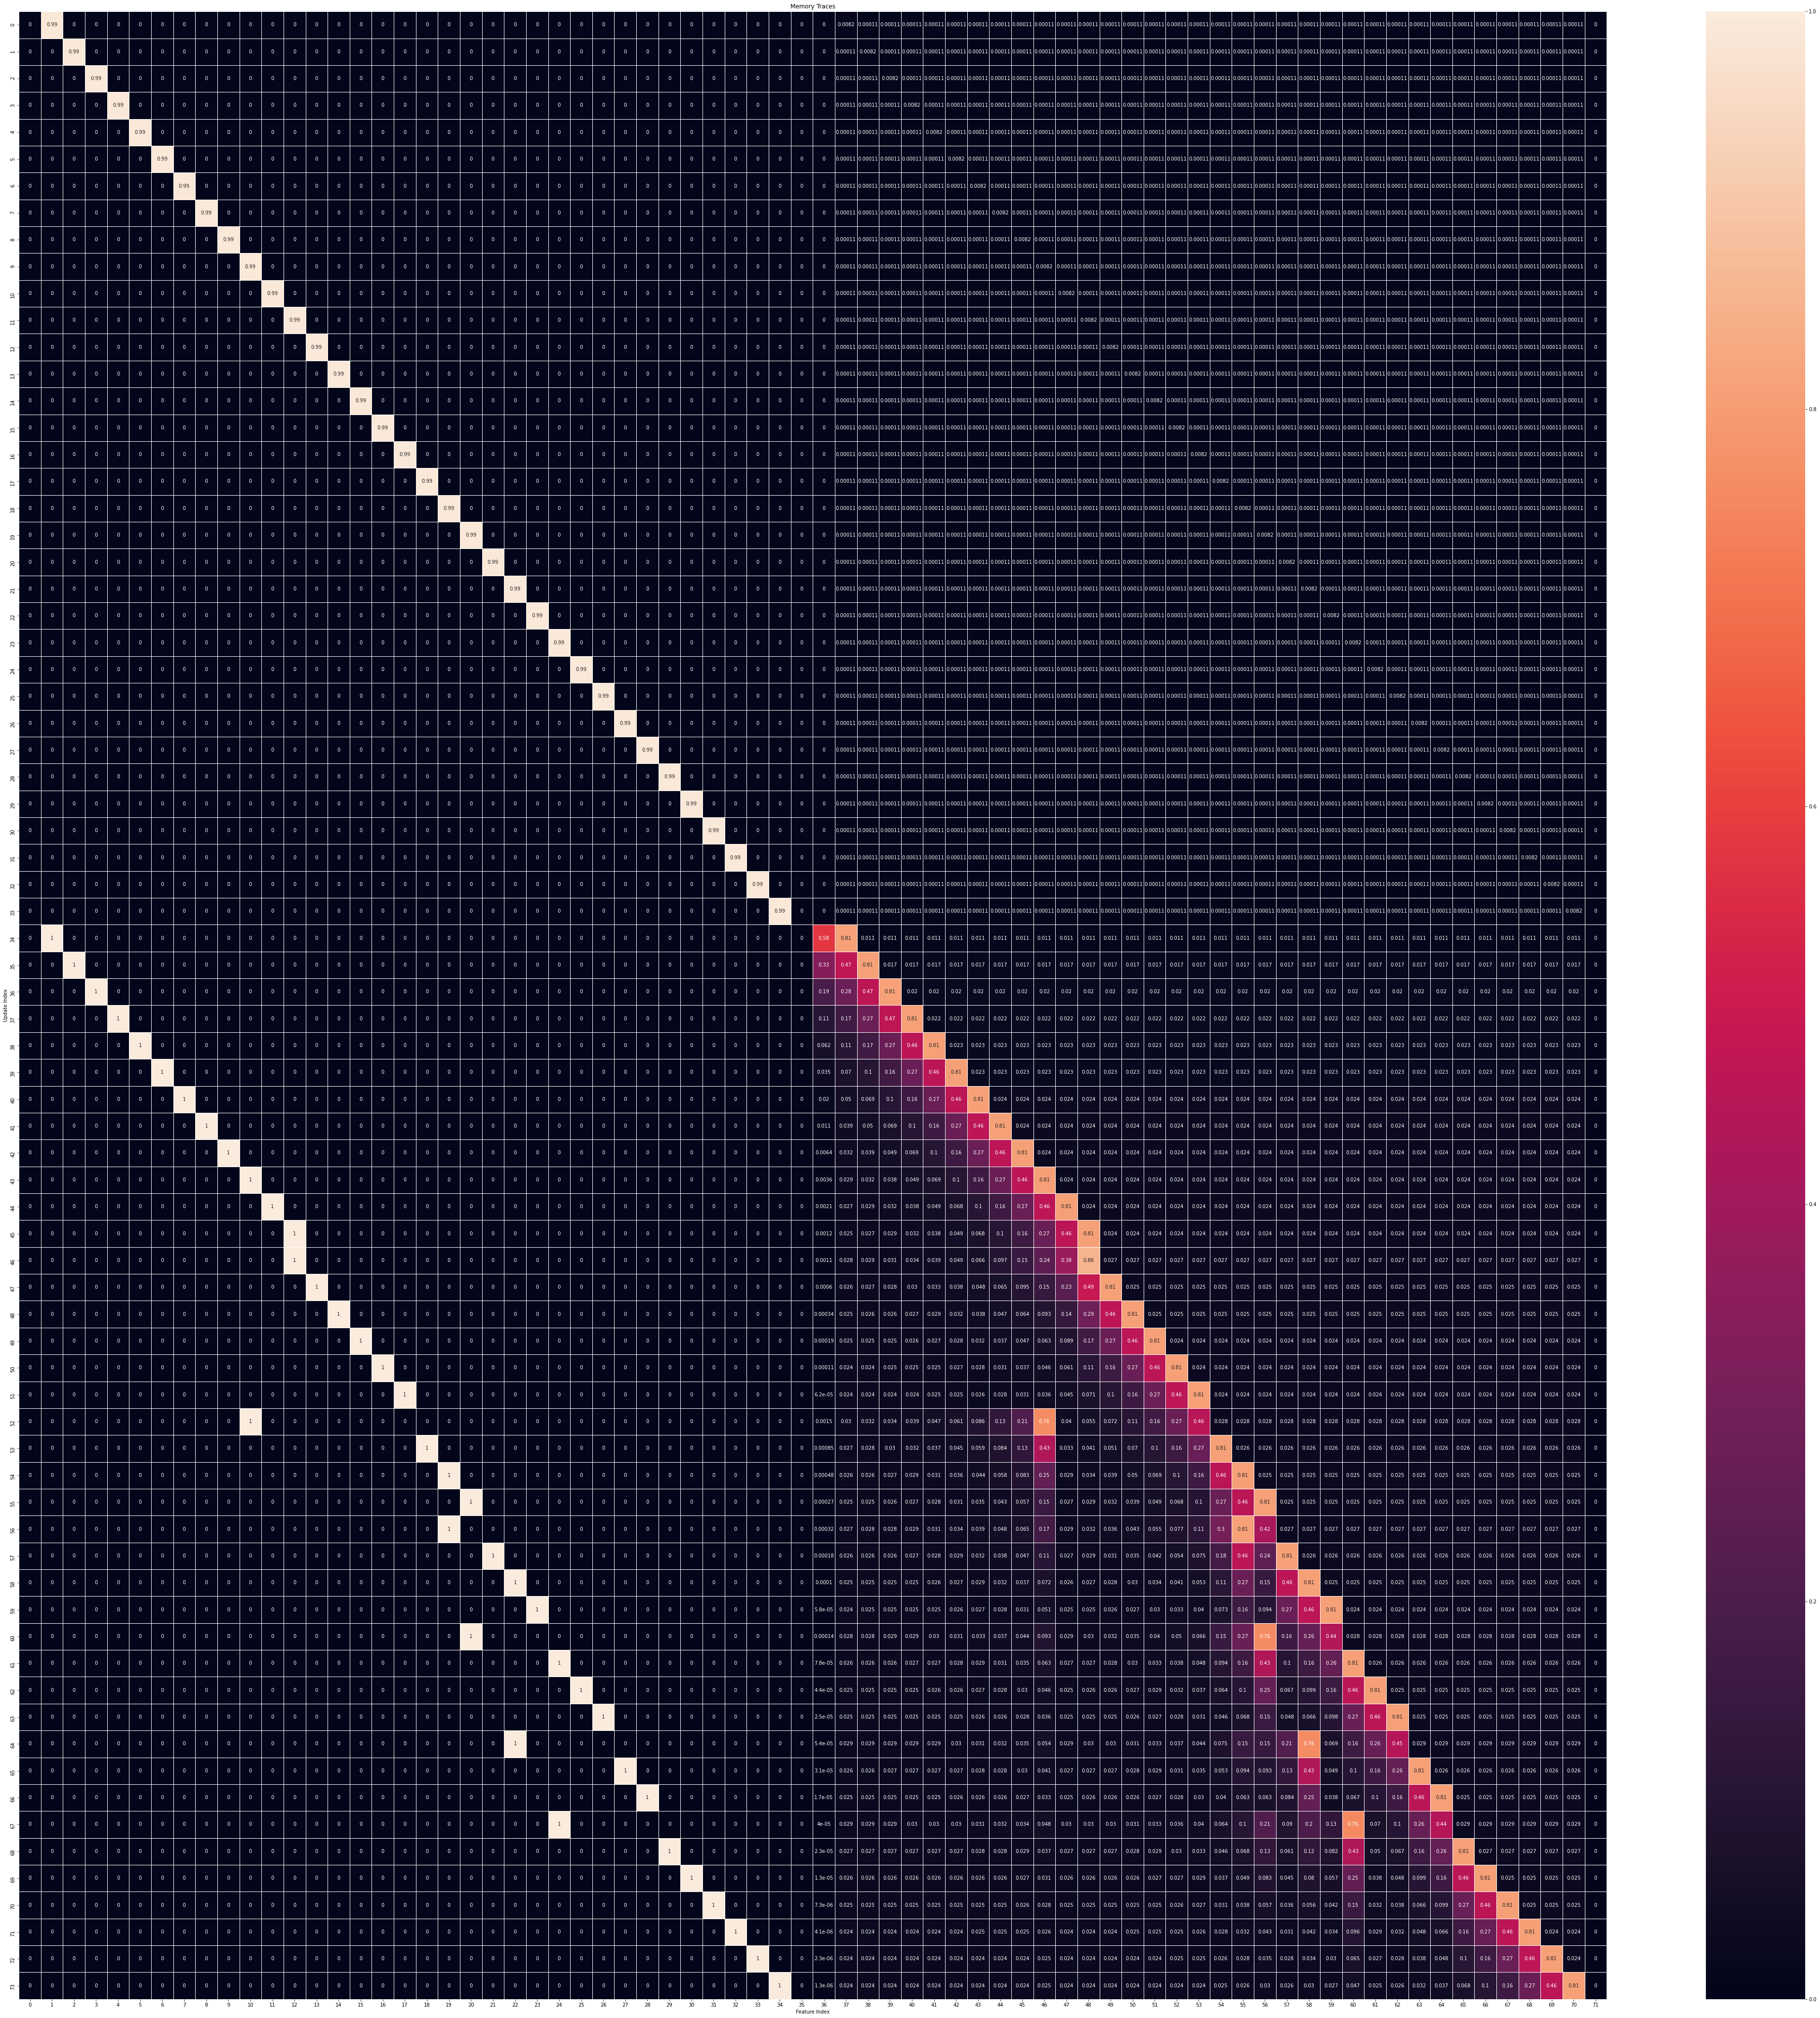

[ 0  1  2  3  4  5  6  7  8  9 10 11 11 12 13 14 15 16  9 17 18 19 18 20
 21 22 19 23 24 25 21 26 27 23 28 29 30 31 32 33]


In [4]:
fitted_parameters = []
for model_index, model_class in enumerate(models):

    fitted_parameters.append(Dict.empty(
        key_type=types.unicode_type, value_type=types.float64
    ))
    for i in range(len(fit_result[model_index])):
        fitted_parameters[-1][free_parameters[model_index][i]] = fit_result[model_index][i]
    for key in fixed_parameters[model_index]:
        fitted_parameters[-1][key] = fixed_parameters[model_index][key]

    model = model_class(list_length, list_length, fitted_parameters[-1])
    simulate_df(model, 1)

    icmr_memory_heatmap(model, just_experimental=True, just_context=False)

    item_count = np.max(presentations[0])+1
    model = model_class(item_count, list_length, fitted_parameters[-1])
    model.experience(model.items[presentations[0]])
    icmr_memory_heatmap(model, just_experimental=False, just_context=False)
    print(presentations[0])

## Benchmark Evaluation

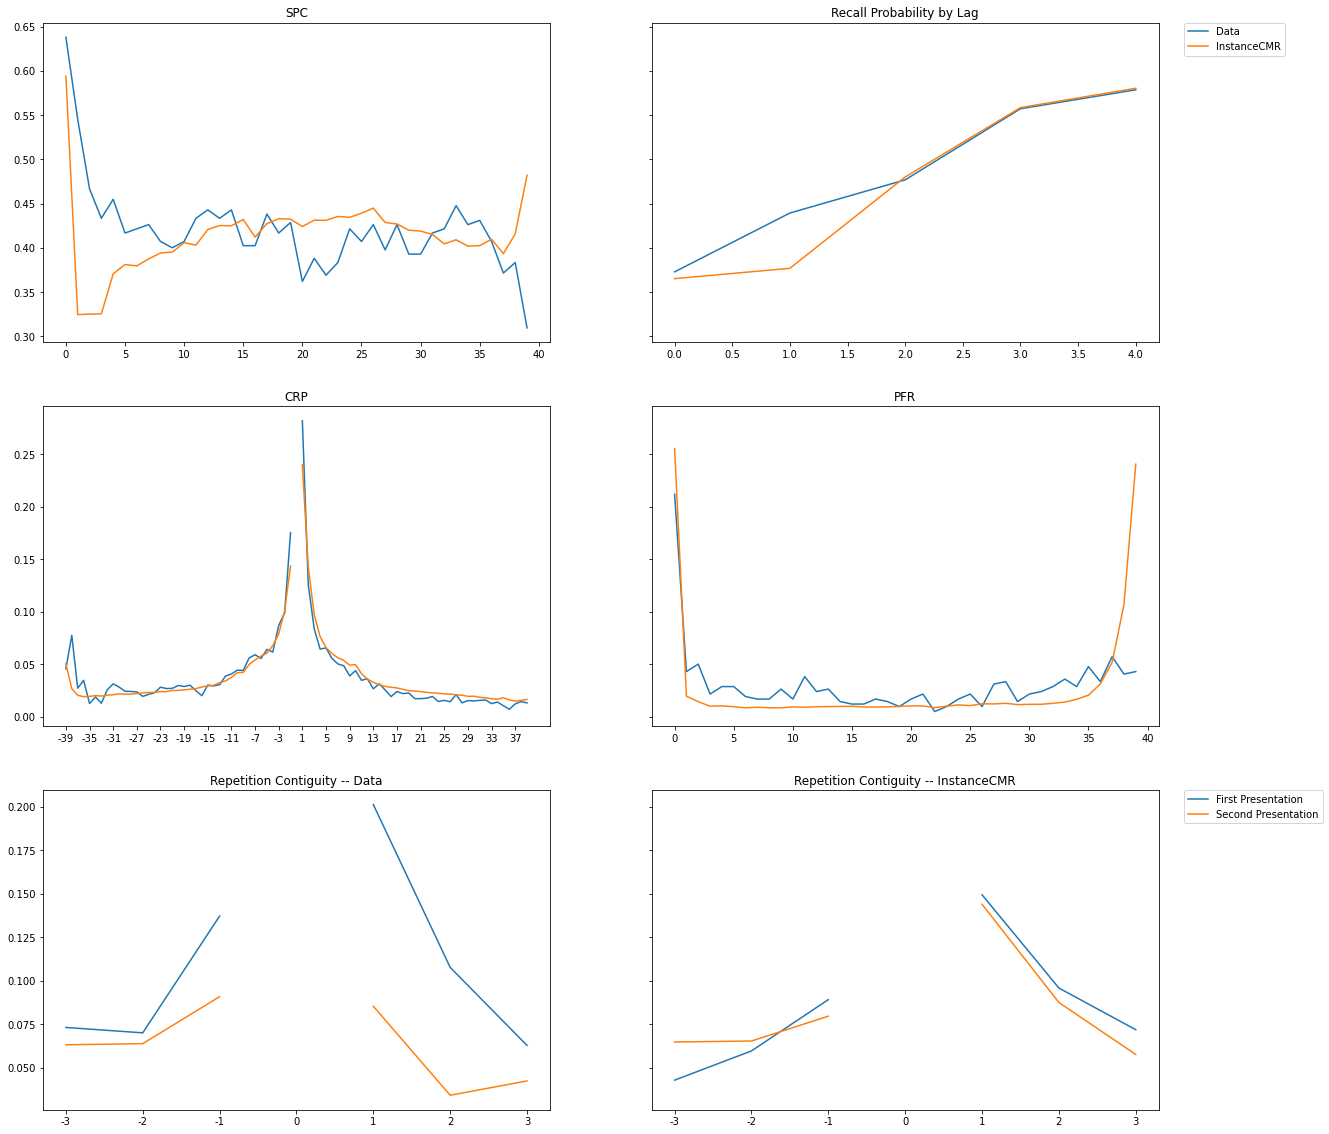

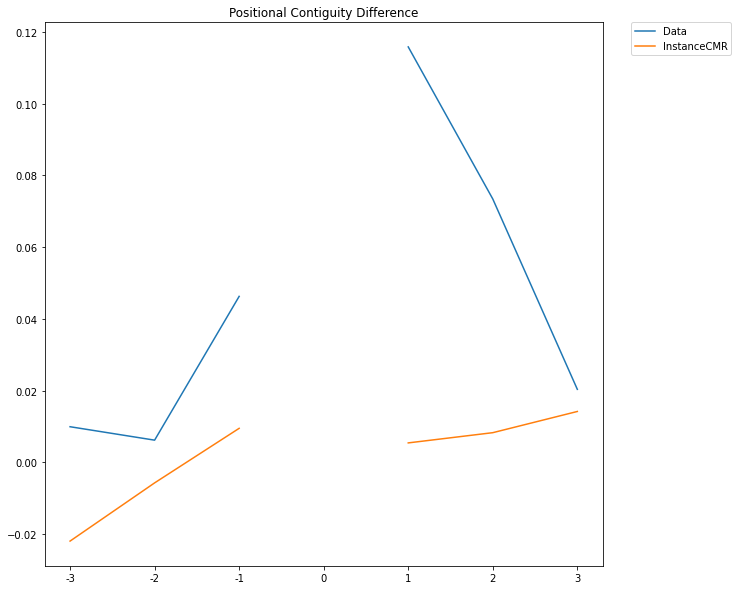

In [5]:
for model_index, model_class in enumerate(models):
    model_name = model_names[model_index]

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)
    
    # first_recalls = np.zeros(len(presentations), dtype=int)
    # for i in range(len(presentations)):
    #     first_recalls[i] = presentations[i][trials[i, 0]-1]+1
        
    sim_trials = simulate_array_from_presentations(
        init_model, fitted_parameters[model_index], presentations, benchmark_experiment_count)
        #init_model, sim_fitted_parameters, presentations, benchmark_experiment_count, first_recalls)
    sim_presentations = np.matlib.repmat(presentations, benchmark_experiment_count, 1)

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), sharey='row')

    # spc
    data_spc= spc(trials, presentations)
    sim_spc = spc(sim_trials, sim_presentations)
    axes[0, 0].plot(np.arange(len(data_spc)), data_spc, label='Data')
    axes[0, 0].plot(np.arange(len(sim_spc)), sim_spc, label=model_name)
    axes[0, 0].set_title('SPC')

    # pfr
    data_pfr = flex_mixed_pfr(trials, presentations)
    sim_pfr = flex_mixed_pfr(sim_trials, sim_presentations)
    axes[1, 1].plot(np.arange(len(data_pfr)), data_pfr, label='Data')
    axes[1, 1].plot(np.arange(len(sim_pfr)), sim_pfr, label=model_name)
    axes[1, 1].set_title('PFR')

    # crp
    lag_range = len(presentations[0])-1
    data_crp= lag_crp(trials, presentations)
    data_crp[lag_range] = np.nan
    sim_crp = lag_crp(sim_trials, sim_presentations)
    sim_crp[lag_range] = np.nan
    axes[1, 0].plot(np.arange(len(data_crp)), data_crp, label='Data')
    axes[1, 0].plot(np.arange(len(sim_crp)), sim_crp, label=model_name)
    axes[1, 0].set_xticks(np.arange(0, len(data_crp), 4))
    axes[1, 0].set_xticklabels(np.arange(0, len(data_crp), 4) - lag_range)
    axes[1, 0].set_title('CRP')

    # rpl
    data_rpl = recall_probability_by_lag(trials, presentations, max_lag=8)
    binned = np.zeros(5)
    binned[0] = data_rpl[0]
    binned[1] = data_rpl[1]
    binned[2] = (data_rpl[2] + data_rpl[3])/2
    binned[3] = (data_rpl[4] + data_rpl[5] + data_rpl[6])/3
    binned[4] = (data_rpl[7] + data_rpl[8] + data_rpl[9])/3
    data_rpl = binned.copy()

    sim_rpl = recall_probability_by_lag(sim_trials, sim_presentations, max_lag=8)
    binned = np.zeros(5)
    binned[0] = sim_rpl[0]
    binned[1] = sim_rpl[1]
    binned[2] = (sim_rpl[2] + sim_rpl[3])/2
    binned[3] = (sim_rpl[4] + sim_rpl[5] + sim_rpl[6])/3
    binned[4] = (sim_rpl[7] + sim_rpl[8] + sim_rpl[9])/3
    sim_rpl = binned.copy()

    axes[0, 1].plot(np.arange(len(data_rpl)), data_rpl, label='Data')
    axes[0, 1].plot(np.arange(len(sim_rpl)), sim_rpl, label=model_name)
    axes[0, 1].set_title('Recall Probability by Lag')

    # rep_ contiguity (data)
    data_rep_crp = repetition_contiguity(
        trials, presentations, 6, 2)
    data_rep_crp[:, lag_range] = np.nan
    axes[2, 0].plot(np.arange(7), data_rep_crp[0][lag_range-3:lag_range+4], label='First Presentation')
    axes[2, 0].plot(np.arange(7), data_rep_crp[1][lag_range-3:lag_range+4], label='Second Presentation')
    axes[2, 0].set_xticks(np.arange(7))
    axes[2, 0].set_xticklabels(np.arange(7) - 3)
    axes[2, 0].set_title('Repetition Contiguity -- Data')

    sim_rep_crp = repetition_contiguity(
        sim_trials, sim_presentations, 6, 2)
    sim_rep_crp[:, lag_range] = np.nan
    axes[2, 1].plot(np.arange(7), sim_rep_crp[0][lag_range-3:lag_range+4], label='First Presentation')
    axes[2, 1].plot(np.arange(7), sim_rep_crp[1][lag_range-3:lag_range+4], label='Second Presentation')
    axes[2, 1].set_xticks(np.arange(7))
    axes[2, 1].set_xticklabels(np.arange(7) - 3)
    axes[2, 1].set_title('Repetition Contiguity -- ' + model_name)

    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes[2, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey='row')

    # repetition contiguity (data)
    data_rep_crp = repetition_contiguity(
        trials, presentations, 6, 2)
    data_rep_crp[:, lag_range] = np.nan
    sim_rep_crp = repetition_contiguity(
        sim_trials, sim_presentations, 6, 2)
    sim_rep_crp[:, lag_range] = np.nan

    axes.plot(np.arange(7), data_rep_crp[0][lag_range-3:lag_range+4]-data_rep_crp[1][lag_range-3:lag_range+4], label='Data')
    axes.plot(np.arange(7), sim_rep_crp[0][lag_range-3:lag_range+4]-sim_rep_crp[1][lag_range-3:lag_range+4], label=model_name)
    axes.set_xticks(np.arange(7))
    axes.set_xticklabels(np.arange(7) - 3)
    axes.set_title('Positional Contiguity Difference')

    axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

## Memory Connectivity

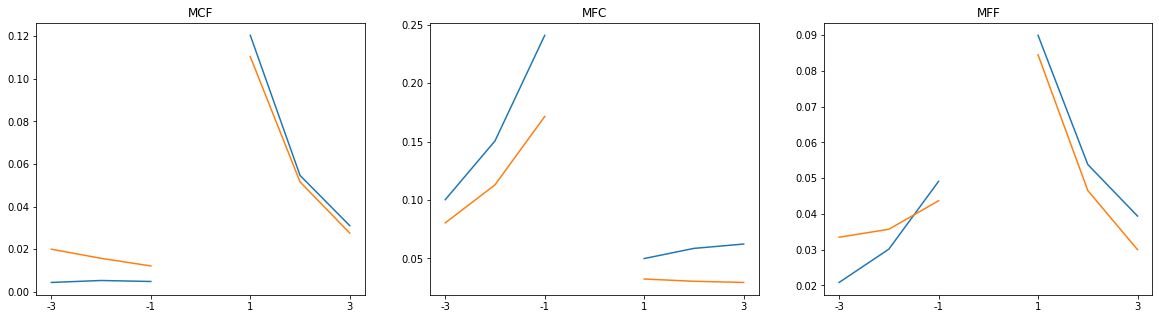

In [6]:
global_lag_range = len(presentations[0]) - 1

for model_index, model_class in enumerate(models):

    mfc_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mcf_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mff_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))

    # loop through presentations
    for trial_index, presentation in enumerate(presentations):

        # simulate list study
        item_count = np.max(presentation)+1
        model = model_class(item_count, len(presentation), fitted_parameters[model_index])
        model.experience(model.items[presentation])

        # extract item connections
        try:
            latent_mfc, mcf_connections, mff_connections = latent_mfc_mcf_mff(model, model.recall_items)
        except:
            latent_mfc, mcf_connections, mff_connections = latent_mfc_mcf_mff(model, model.items)
        mfc_connections = latent_mfc[:, 1:-1]

        # track alternative connectivity
        mfc_alternative_connectivities += repetition_connectivity_by_lag(mfc_connections, presentation)
        mcf_alternative_connectivities += repetition_connectivity_by_lag(mcf_connections, presentation)
        mff_alternative_connectivities += repetition_connectivity_by_lag(mff_connections, presentation)

    # reduce sum to mean
    mfc_alternative_connectivity = mfc_alternative_connectivities / (trial_index+1)
    mcf_alternative_connectivity = mcf_alternative_connectivities / (trial_index+1)
    mff_alternative_connectivity = mff_alternative_connectivities / (trial_index+1)
    mfc_alternative_connectivity[:, global_lag_range] = np.nan
    mcf_alternative_connectivity[:, global_lag_range] = np.nan
    mff_alternative_connectivity[:, global_lag_range] = np.nan

    # focus on +/- 3 lags
    plotting_lag_range = 3
    mfc_alternative_connectivity = mfc_alternative_connectivity[
        :, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]
    mcf_alternative_connectivity = mcf_alternative_connectivity[
        :, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]
    mff_alternative_connectivity = mff_alternative_connectivity[
        :, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]

    # plot results
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey=False)
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[0])), mcf_alternative_connectivity[0], label='First Presentation')
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[1])), mcf_alternative_connectivity[1], label='Second Presentation')
    axes[0].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[0].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[0].set_title('MCF')

    # same for MFC
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[0])), mfc_alternative_connectivity[0], label='First Presentation')
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[1])), mfc_alternative_connectivity[1], label='Second Presentation')
    axes[1].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[1].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[1].set_title('MFC')

    # same for MFF
    axes[2].plot(np.arange(len(mff_alternative_connectivity[0])), mff_alternative_connectivity[0], label='First Presentation')
    axes[2].plot(np.arange(len(mff_alternative_connectivity[1])), mff_alternative_connectivity[1], label='Second Presentation')
    axes[2].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[2].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[2].set_title('MFF')


## Parameter Shifting

  0%|          | 0/9 [00:00<?, ?it/s]

context_sensitivity 1.6093244141764889
[1. 2. 3. 4. 5. 6. 7. 8. 9.]


100%|██████████| 9/9 [11:10<00:00, 74.53s/it]


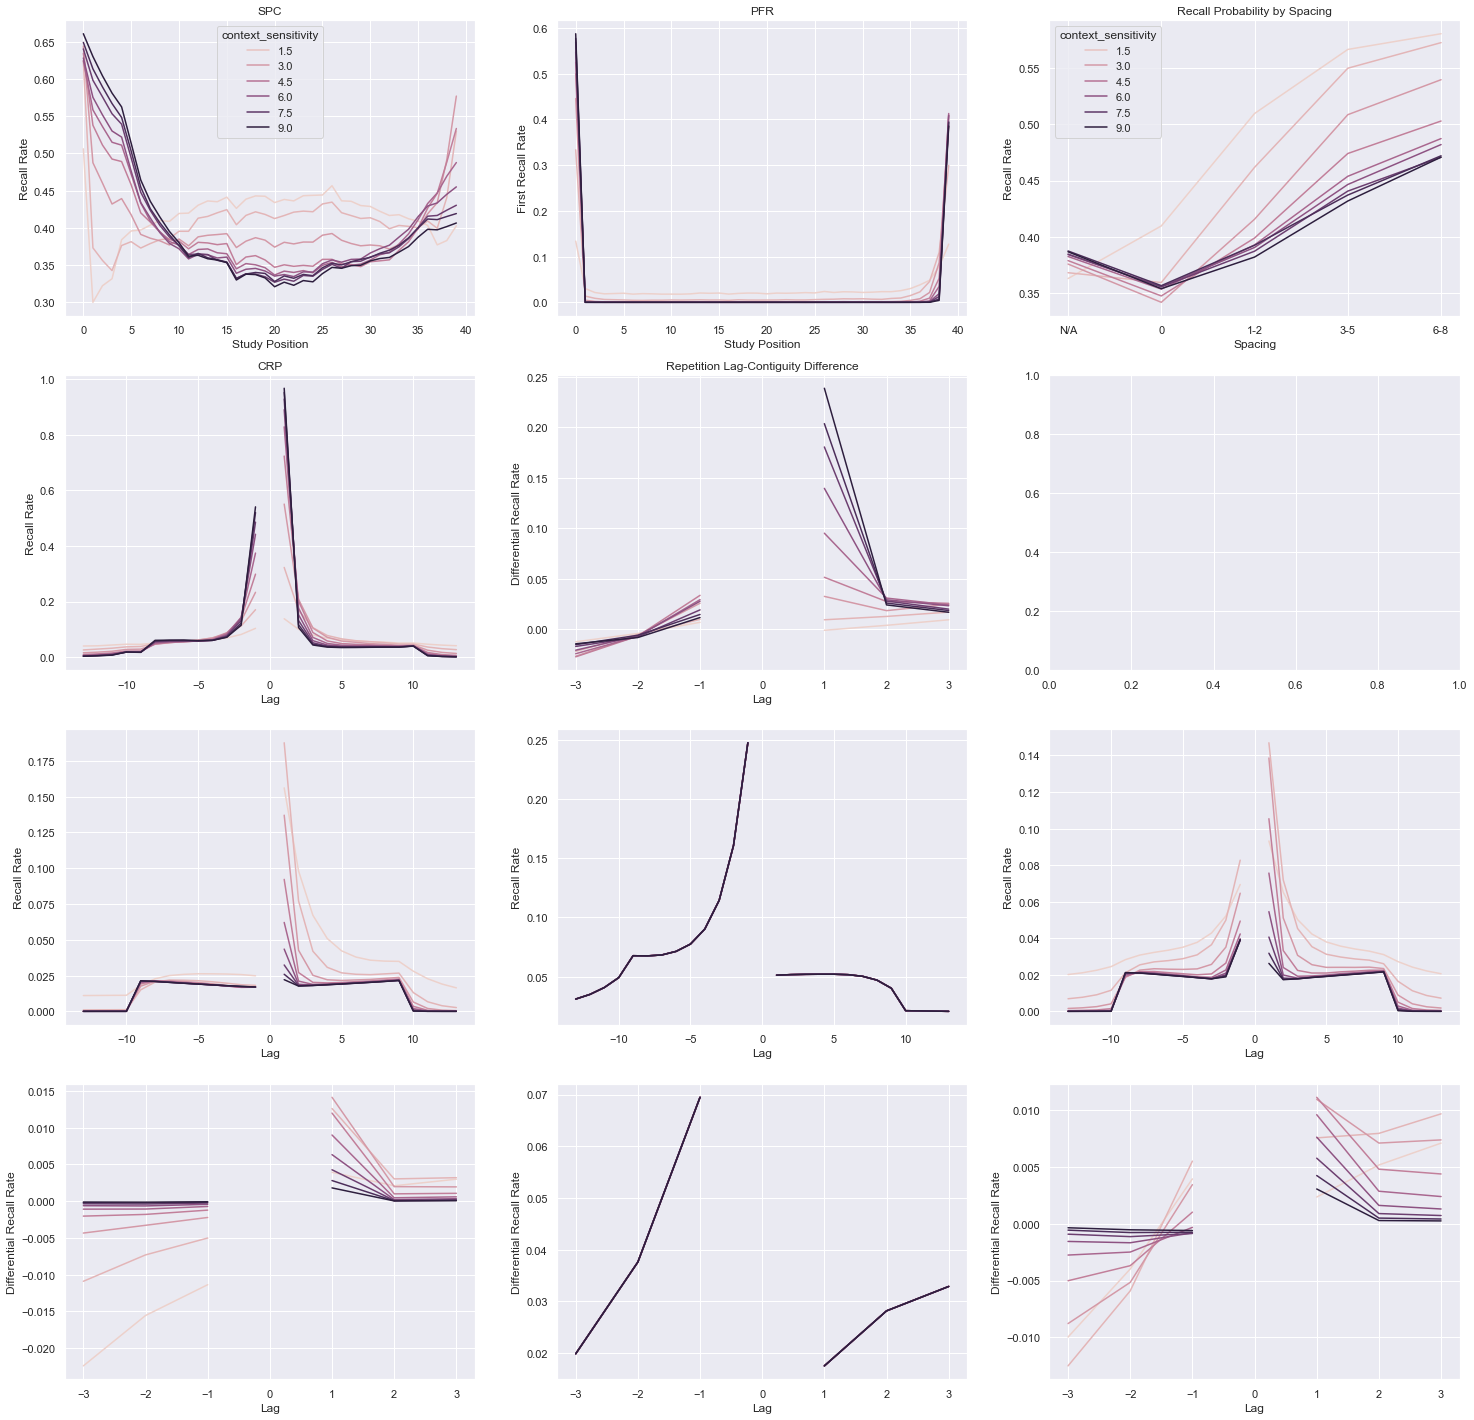

  0%|          | 0/10 [00:00<?, ?it/s]

mcf_familiarity_scale 0.9999999999999998
[0.001 0.101 0.201 0.301 0.401 0.501 0.601 0.701 0.801 0.901]


100%|██████████| 10/10 [12:39<00:00, 75.95s/it]


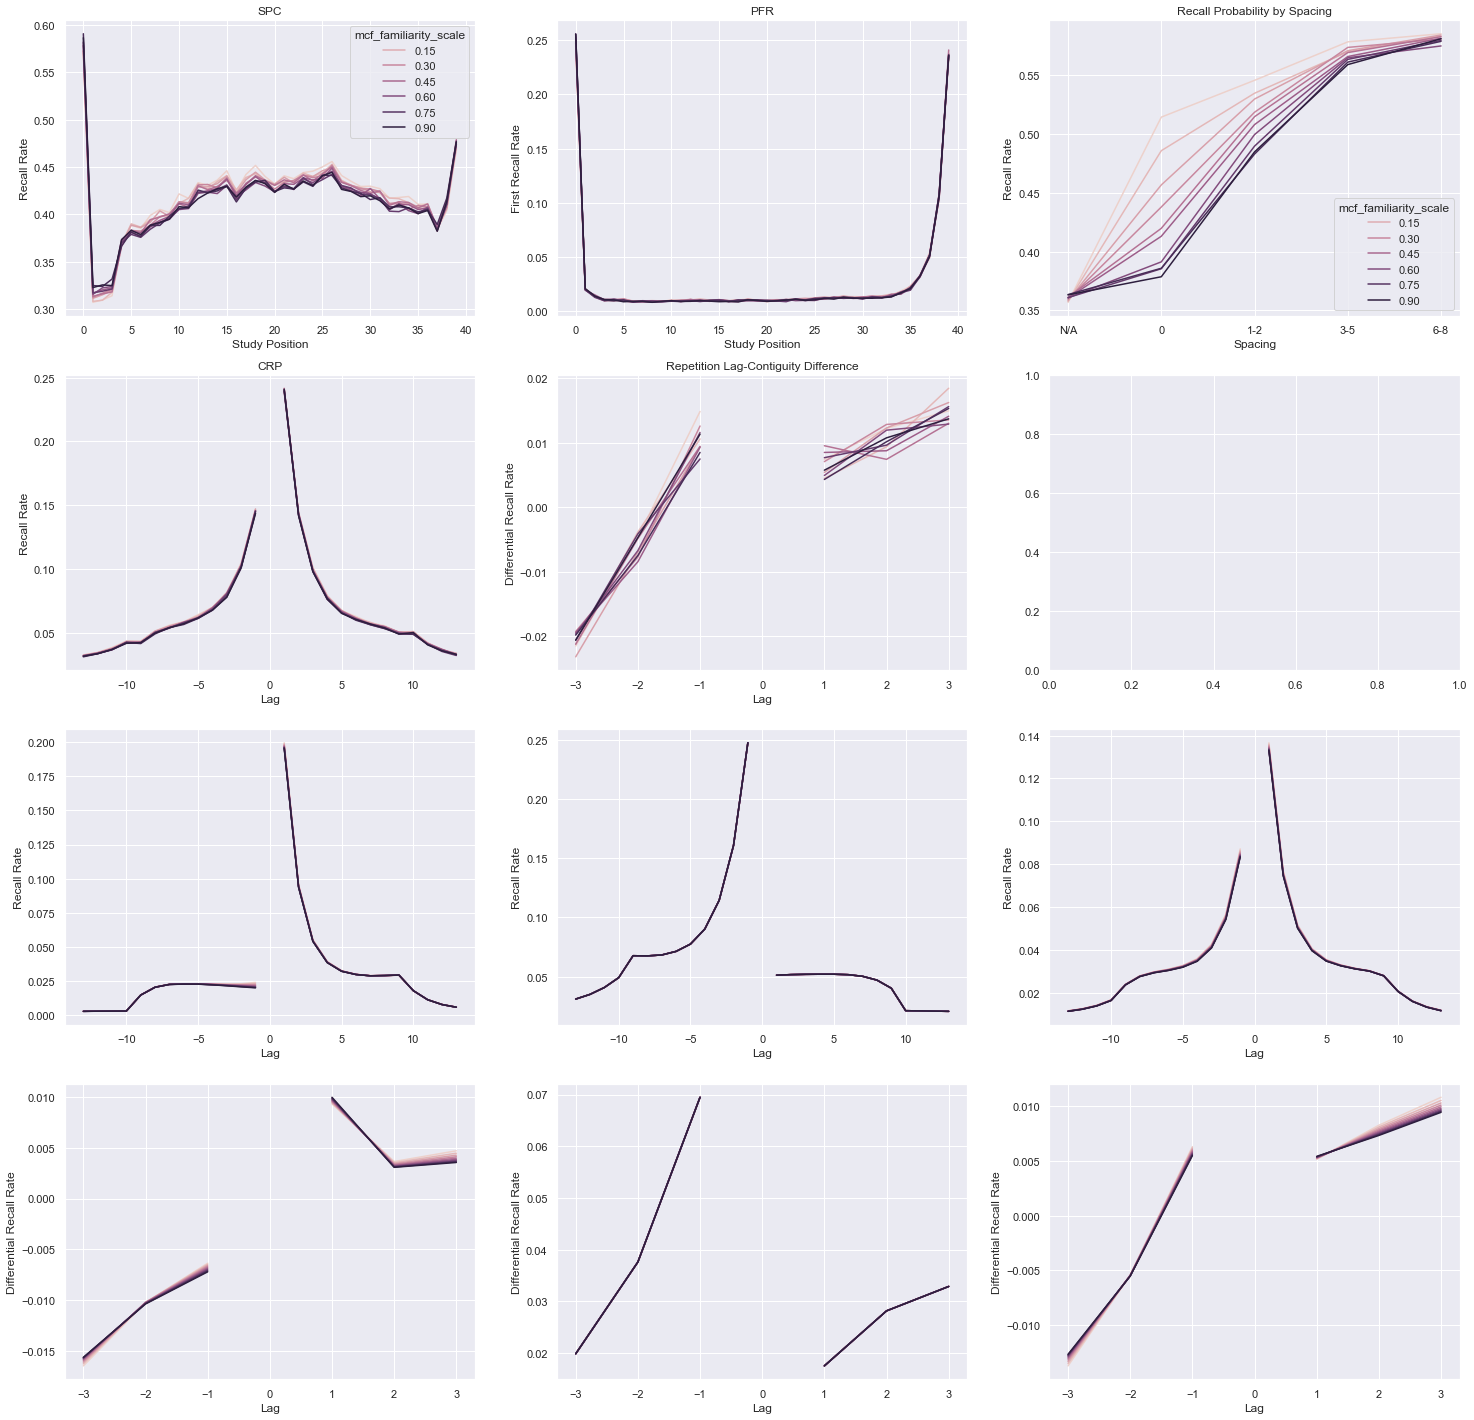

In [7]:
global_lag_range = list_length-1
crp_max_lag = 13
rep_crp_max_lag = 3
sim_presentations = np.matlib.repmat(presentations, parameter_shifting_experiment_count, 1)

for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    for varied_parameter in parameter_ranges.keys():

        print(varied_parameter, fitted_parameters[model_index][varied_parameter])
        print(parameter_ranges[varied_parameter])
        spcs = []
        pfrs = []
        rpls = []
        crps = []
        rep_crps = []
        lag_mcfs = []
        lag_mfcs = []
        lag_mffs = []
        rep_lag_mcfs = []
        rep_lag_mfcs = []
        rep_lag_mffs = []

        # loop through parameter values
        for parameter_value in tqdm(parameter_ranges[varied_parameter]):

            # simulate data with this parameter value modified
            model_parameters = fitted_parameters[model_index].copy()
            model_parameters[varied_parameter] = parameter_value
            sim_trials = simulate_array_from_presentations(
                init_model, model_parameters, presentations, parameter_shifting_experiment_count)

            # spc
            sim_spc = spc(sim_trials, sim_presentations)
            sim_spc = pd.DataFrame(
                    {'Study Position': np.arange(len(sim_spc)), 'Recall Rate': sim_spc, varied_parameter: parameter_value})
            spcs.append(sim_spc)

            # pfr
            sim_pfr = flex_mixed_pfr(sim_trials, sim_presentations)
            sim_pfr = pd.DataFrame(
                {'Study Position': np.arange(len(sim_pfr)), 'First Recall Rate': sim_pfr, varied_parameter: parameter_value})
            pfrs.append(sim_pfr)

            # rpl
            rpl = recall_probability_by_lag(
                sim_trials, sim_presentations, max_lag=8)
            binned = np.zeros(5)
            binned[0] = rpl[0]
            binned[1] = rpl[1]
            binned[2] = (rpl[2] + rpl[3])/2
            binned[3] = (rpl[4] + rpl[5] + rpl[6])/3
            binned[4] = (rpl[7] + rpl[8] + rpl[9])/3
            rpl = binned.copy()
            rpl = pd.DataFrame(
                {'Spacing': ['N/A', '0', '1-2', '3-5', '6-8'], 'Recall Rate': rpl, varied_parameter: parameter_value})
            rpls.append(rpl)

            # crp
            sim_crp = lag_crp(sim_trials, sim_presentations)
            sim_crp[global_lag_range] = np.nan
            sim_crp = pd.DataFrame(
                {'Lag': np.arange(crp_max_lag*2 + 1, dtype=int)-crp_max_lag, 
                'Recall Rate': sim_crp[list_length-crp_max_lag-1:list_length+crp_max_lag], 
                varied_parameter: parameter_value})
            crps.append(sim_crp)

            # rep crp
            rep_crp = repetition_contiguity(
                sim_trials, sim_presentations, 6, 2)
            rep_crp[:, global_lag_range] = np.nan
            rep_crp = pd.DataFrame({
                    "Lag": np.arange(rep_crp_max_lag * 2 + 1, dtype=int) - rep_crp_max_lag,
                    "Differential Recall Rate": rep_crp[0, list_length-rep_crp_max_lag-1:list_length + rep_crp_max_lag]
                        - rep_crp[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag],
                    varied_parameter: parameter_value,
                })
            rep_crps.append(rep_crp)

            # lag-connectivity requires more involved computations...
            total_lag_mfc = np.zeros((global_lag_range * 2 + 1))
            total_lag_mcf = np.zeros((global_lag_range * 2 + 1))
            total_lag_mff = np.zeros((global_lag_range * 2 + 1))
            total_rep_lag_mfc = np.zeros((2, global_lag_range * 2 + 1))
            total_rep_lag_mcf = np.zeros((2, global_lag_range * 2 + 1))
            total_rep_lag_mff = np.zeros((2, global_lag_range * 2 + 1))

            # loop through presentations
            for trial_index, presentation in enumerate(presentations):

                # simulate list study
                item_count = np.max(presentation)+1
                model = model_class(item_count, len(presentation), model_parameters)
                model.experience(model.items[presentation])

                # extract item connections
                try:
                    latent_mfc, mcf_connections, mff_connections = latent_mfc_mcf_mff(model, model.recall_items)
                except:
                    latent_mfc, mcf_connections, mff_connections = latent_mfc_mcf_mff(model, model.items)
                mfc_connections = latent_mfc[:, 1:-1]

                # track repetition connectivity
                total_rep_lag_mfc += repetition_connectivity_by_lag(mfc_connections, presentation)
                total_rep_lag_mcf += repetition_connectivity_by_lag(mcf_connections, presentation)
                total_rep_lag_mff += repetition_connectivity_by_lag(mff_connections, presentation)

                # and overall connectivity
                total_lag_mfc += mixed_connectivity_by_lag(mfc_connections, presentation)
                total_lag_mcf += mixed_connectivity_by_lag(mcf_connections, presentation)
                total_lag_mff += mixed_connectivity_by_lag(mff_connections, presentation)

            # reduce sum to mean
            # repetition connectivity
            rep_lag_mfc = total_rep_lag_mfc / (trial_index+1)
            rep_lag_mcf = total_rep_lag_mcf / (trial_index+1)
            rep_lag_mff = total_rep_lag_mff / (trial_index+1)
            rep_lag_mfc[:, global_lag_range] = np.nan
            rep_lag_mcf[:, global_lag_range] = np.nan
            rep_lag_mff[:, global_lag_range] = np.nan

            # overall connectivity
            lag_mfc = total_lag_mfc / (trial_index+1)
            lag_mcf = total_lag_mcf / (trial_index+1)
            lag_mff = total_lag_mff / (trial_index+1)
            lag_mfc[global_lag_range] = np.nan
            lag_mcf[global_lag_range] = np.nan
            lag_mff[global_lag_range] = np.nan

            # aggregate for dataframe
            rep_lag_mfc = pd.DataFrame(
                {'Lag': np.arange(rep_crp_max_lag*2+1, dtype=int)-rep_crp_max_lag,
                'Differential Recall Rate': rep_lag_mfc[0, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag]
                - rep_lag_mfc[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag],
                varied_parameter: parameter_value})
            rep_lag_mcf = pd.DataFrame(
                {'Lag': np.arange(rep_crp_max_lag*2+1, dtype=int)-rep_crp_max_lag,
                'Differential Recall Rate': rep_lag_mcf[0, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag]
                - rep_lag_mcf[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag],
                varied_parameter: parameter_value})
            rep_lag_mff = pd.DataFrame(
                {'Lag': np.arange(rep_crp_max_lag*2+1, dtype=int)-rep_crp_max_lag,
                'Differential Recall Rate': rep_lag_mff[0, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag]
                - rep_lag_mff[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag],
                varied_parameter: parameter_value})

            lag_mfc = pd.DataFrame(
                {'Lag': np.arange(crp_max_lag*2+1, dtype=int)-crp_max_lag,
                'Recall Rate': lag_mfc[list_length-crp_max_lag-1:list_length+crp_max_lag],
                varied_parameter: parameter_value})
            lag_mcf = pd.DataFrame(
                {'Lag': np.arange(crp_max_lag*2+1, dtype=int)-crp_max_lag,
                'Recall Rate': lag_mcf[list_length-crp_max_lag-1:list_length+crp_max_lag],
                varied_parameter: parameter_value})
            lag_mff = pd.DataFrame(
                {'Lag': np.arange(crp_max_lag*2+1, dtype=int)-crp_max_lag,
                'Recall Rate': lag_mff[list_length-crp_max_lag-1:list_length+crp_max_lag],
                varied_parameter: parameter_value})

            rep_lag_mcfs.append(rep_lag_mcf)
            rep_lag_mffs.append(rep_lag_mff)
            rep_lag_mfcs.append(rep_lag_mfc)
            lag_mcfs.append(lag_mcf)
            lag_mffs.append(lag_mff)
            lag_mfcs.append(lag_mfc)
        
        # aggregate fitting results
        full_spc = pd.concat(spcs).reset_index()
        full_pfr = pd.concat(pfrs).reset_index()
        full_crp = pd.concat(crps).reset_index()
        rpl = pd.concat(rpls).reset_index()
        rep_crp = pd.concat(rep_crps).reset_index()
        lag_mcf = pd.concat(lag_mcfs).reset_index()
        lag_mff = pd.concat(lag_mffs).reset_index()
        lag_mfc = pd.concat(lag_mfcs).reset_index()
        rep_lag_mcf = pd.concat(rep_lag_mcfs).reset_index()
        rep_lag_mff = pd.concat(rep_lag_mffs).reset_index()
        rep_lag_mfc = pd.concat(rep_lag_mfcs).reset_index()

        # plot results
        sns.set(style='darkgrid')
        fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(25, 25), sharey=False)

        # spc
        sns.lineplot(ax=axes[0, 0], data=full_spc, x='Study Position', y='Recall Rate', hue=varied_parameter, ci=None)
        axes[0, 0].set_title('SPC')

        # pfr
        sns.lineplot(ax=axes[0, 1], data=full_pfr, x='Study Position', y='First Recall Rate', hue=varied_parameter, ci=None, legend=False)
        axes[0, 1].set_title('PFR')

        # rpl (should be rps)
        sns.lineplot(ax=axes[0, 2], data=rpl, x='Spacing', y='Recall Rate', hue=varied_parameter, ci=None)
        axes[0, 2].set_title('Recall Probability by Spacing')

        # crp
        filt_neg = f'{-crp_max_lag} <= Lag < 0'
        filt_pos = f'0 < Lag <= {crp_max_lag}'
        sns.lineplot(ax=axes[1, 0], data=full_crp.query(filt_neg), x='Lag', y='Recall Rate', 
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[1, 0], data=full_crp.query(filt_pos), x='Lag', y='Recall Rate', 
            hue=varied_parameter, ci=None, legend=False)
        axes[1, 0].set_title('CRP')

        # rep_crp
        sns.lineplot(ax=axes[1, 1], data=rep_crp.query(filt_neg), x='Lag', y="Differential Recall Rate", 
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[1, 1], data=rep_crp.query(filt_pos), x='Lag', y="Differential Recall Rate", 
            hue=varied_parameter, ci=None, legend=False)
        axes[1, 1].set_title('Repetition Lag-Contiguity Difference')

        # lag_mcf
        sns.lineplot(ax=axes[2, 0], data=lag_mcf.query(filt_neg), x='Lag', y='Recall Rate',
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[2, 0], data=lag_mcf.query(filt_pos), x='Lag', y='Recall Rate',
            hue=varied_parameter, ci=None, legend=False)

        # lag_mfc
        sns.lineplot(ax=axes[2, 1], data=lag_mfc.query(filt_neg), x='Lag', y='Recall Rate',
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[2, 1], data=lag_mfc.query(filt_pos), x='Lag', y='Recall Rate',
            hue=varied_parameter, ci=None, legend=False)

        # lag_mff
        sns.lineplot(ax=axes[2, 2], data=lag_mff.query(filt_neg), x='Lag', y='Recall Rate',
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[2, 2], data=lag_mff.query(filt_pos), x='Lag', y='Recall Rate',
            hue=varied_parameter, ci=None, legend=False)

        # rep_lag_mcf
        sns.lineplot(ax=axes[3, 0], data=rep_lag_mcf.query(filt_neg), x='Lag', y='Differential Recall Rate',
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[3, 0], data=rep_lag_mcf.query(filt_pos), x='Lag', y='Differential Recall Rate',
            hue=varied_parameter, ci=None, legend=False)

        # rep_lag_mfc
        sns.lineplot(ax=axes[3, 1], data=rep_lag_mfc.query(filt_neg), x='Lag', y='Differential Recall Rate',
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[3, 1], data=rep_lag_mfc.query(filt_pos), x='Lag', y='Differential Recall Rate',
            hue=varied_parameter, ci=None, legend=False)

        # rep_lag_mff
        sns.lineplot(ax=axes[3, 2], data=rep_lag_mff.query(filt_neg), x='Lag', y='Differential Recall Rate',
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[3, 2], data=rep_lag_mff.query(filt_pos), x='Lag', y='Differential Recall Rate',
            hue=varied_parameter, ci=None, legend=False)

        # render result
        plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

context_sensitivity 1.6093244141764889


100%|██████████| 9/9 [04:09<00:00, 27.75s/it]


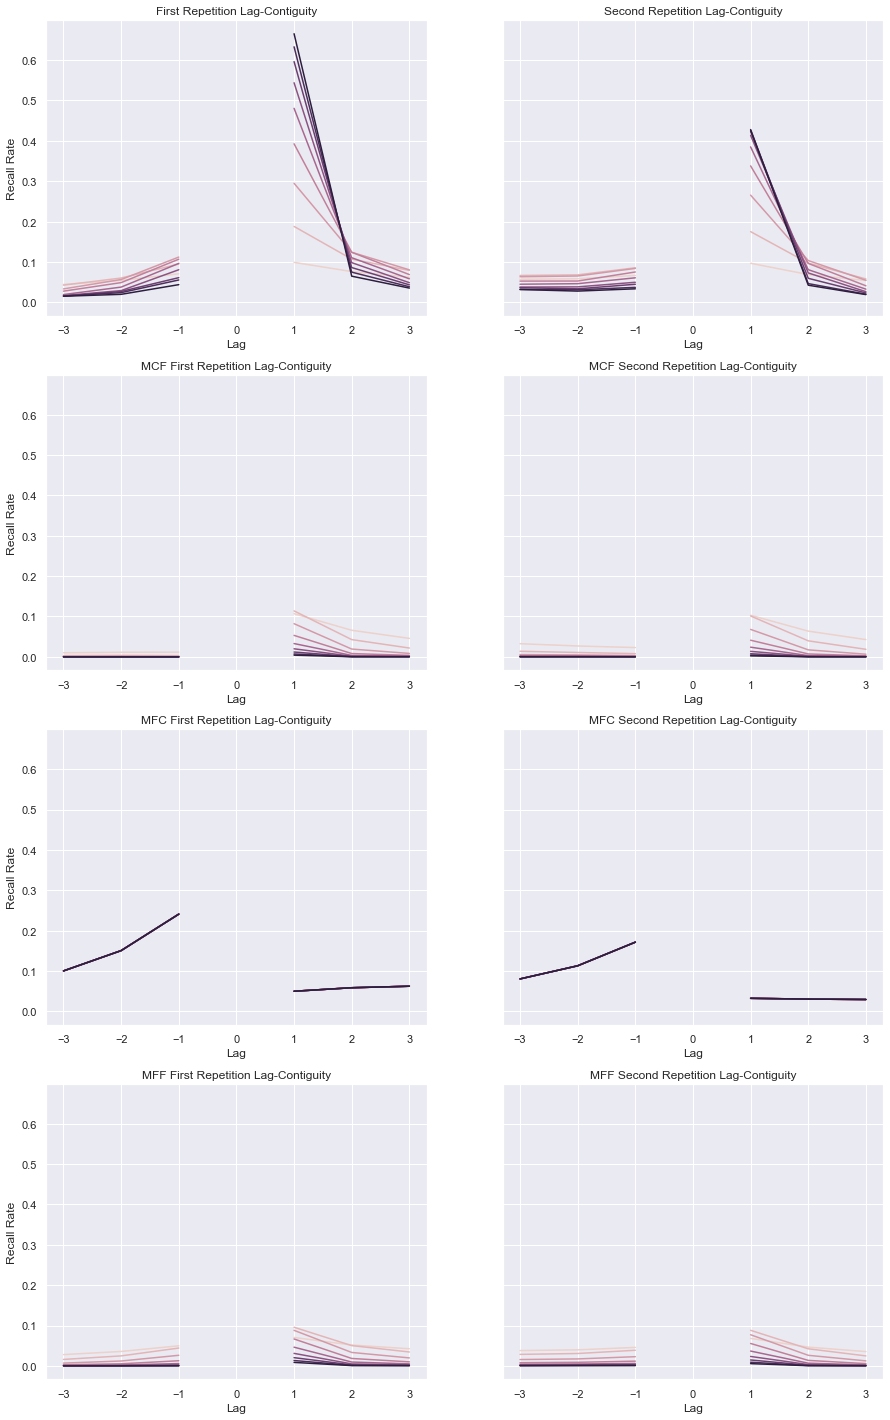

  0%|          | 0/10 [00:00<?, ?it/s]

mcf_familiarity_scale 0.9999999999999998


100%|██████████| 10/10 [04:30<00:00, 27.04s/it]


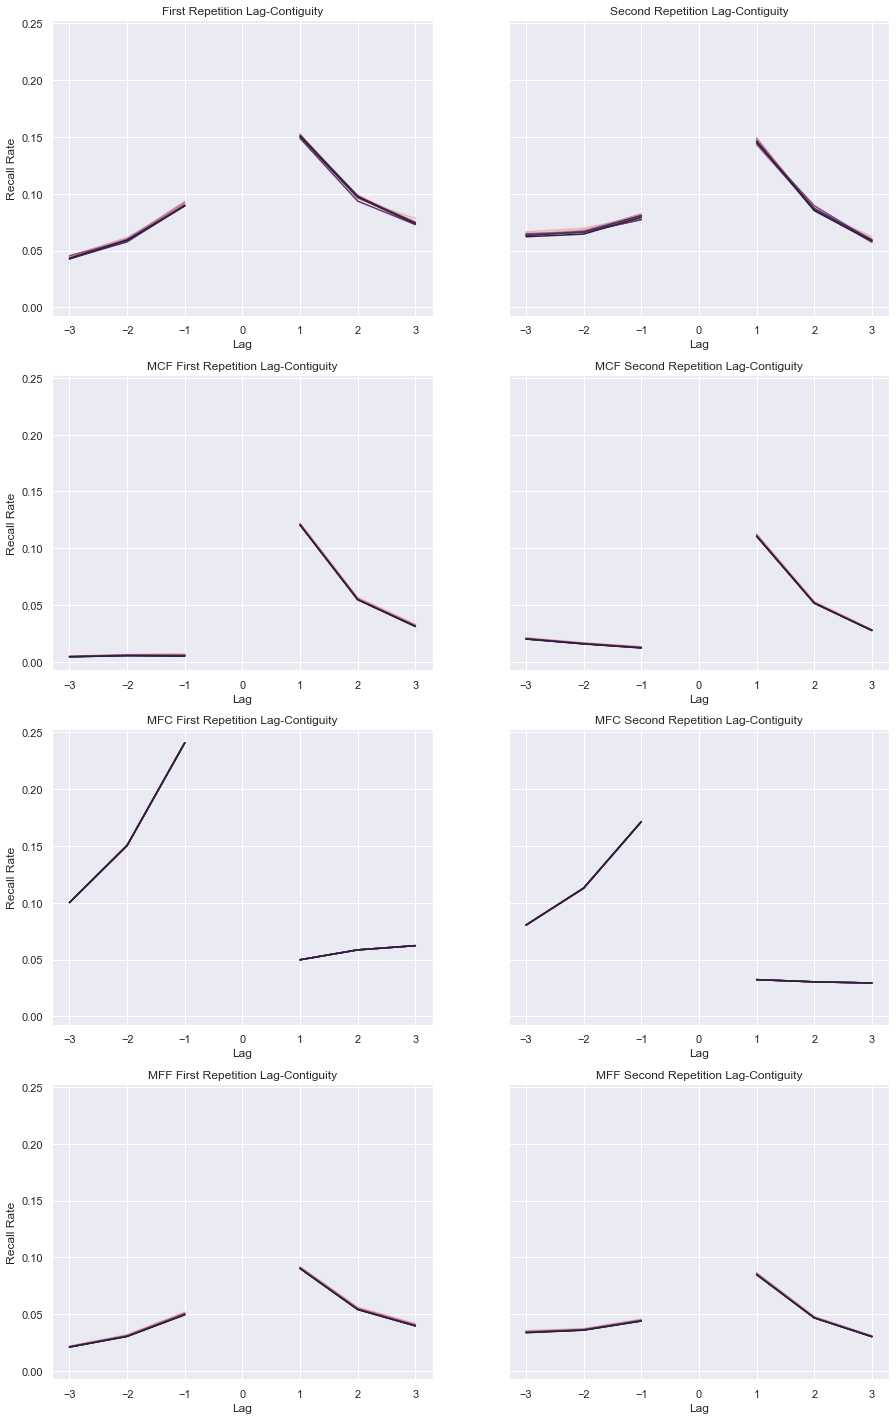

In [8]:
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)
        
    for varied_parameter in parameter_ranges.keys():

        print(varied_parameter, fitted_parameters[model_index][varied_parameter])
        rep_crps = []
        rep_lag_mcfs = []
        rep_lag_mfcs = []
        rep_lag_mffs = []

        # loop through parameter values
        for parameter_value in tqdm(parameter_ranges[varied_parameter]):

            # simulate data with this parameter value modified
            model_parameters = fitted_parameters[model_index].copy()
            model_parameters[varied_parameter] = parameter_value
            sim_trials = simulate_array_from_presentations(
                init_model, model_parameters, presentations, parameter_shifting_experiment_count)
            

            # rep crp
            rep_crp = repetition_contiguity(sim_trials, sim_presentations, 6, 2)
            rep_crp[:, global_lag_range] = np.nan
            rep_crp = pd.DataFrame({
                    "Lag": (np.arange(rep_crp_max_lag*2+1, dtype=int)-rep_crp_max_lag).tolist() * 2,
                    "Recall Rate": rep_crp[0, list_length-rep_crp_max_lag-1:list_length + rep_crp_max_lag].tolist()
                        + rep_crp[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag].tolist(),
                    varied_parameter: parameter_value,
                    "Position": ['First'] * (rep_crp_max_lag*2+1) + ['Second'] * (rep_crp_max_lag*2+1)
                })
            rep_crps.append(rep_crp)

            # lag-connectivity requires more involved computations...
            total_rep_lag_mfc = np.zeros((2, global_lag_range * 2 + 1))
            total_rep_lag_mcf = np.zeros((2, global_lag_range * 2 + 1))
            total_rep_lag_mff = np.zeros((2, global_lag_range * 2 + 1))

            # loop through presentations
            for trial_index, presentation in enumerate(presentations):

                # simulate list study
                item_count = np.max(presentation)+1
                model = model_class(item_count, len(presentation), model_parameters)
                model.experience(model.items[presentation])

                # extract item connections
                try:
                    latent_mfc, mcf_connections, mff_connections = latent_mfc_mcf_mff(model, model.recall_items)
                except:
                    latent_mfc, mcf_connections, mff_connections = latent_mfc_mcf_mff(model, model.items)
                mfc_connections = latent_mfc[:, 1:-1]

                # track repetition connectivity
                total_rep_lag_mfc += repetition_connectivity_by_lag(mfc_connections, presentation)
                total_rep_lag_mcf += repetition_connectivity_by_lag(mcf_connections, presentation)
                total_rep_lag_mff += repetition_connectivity_by_lag(mff_connections, presentation)

            # reduce sum to mean
            # repetition connectivity
            rep_lag_mfc = total_rep_lag_mfc / (trial_index+1)
            rep_lag_mcf = total_rep_lag_mcf / (trial_index+1)
            rep_lag_mff = total_rep_lag_mff / (trial_index+1)
            rep_lag_mfc[:, global_lag_range] = np.nan
            rep_lag_mcf[:, global_lag_range] = np.nan
            rep_lag_mff[:, global_lag_range] = np.nan

            # aggregate for dataframe
            rep_lag_mfc = pd.DataFrame(
                {'Lag': (np.arange(rep_crp_max_lag*2+1, dtype=int)-rep_crp_max_lag).tolist() * 2,
                'Recall Rate': rep_lag_mfc[0, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag].tolist()
                + rep_lag_mfc[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag].tolist(),
                varied_parameter: parameter_value,
                "Position": ['First'] * (rep_crp_max_lag*2+1) + ['Second'] * (rep_crp_max_lag*2+1)})
            rep_lag_mcf = pd.DataFrame(
                {'Lag': (np.arange(rep_crp_max_lag*2+1, dtype=int)-rep_crp_max_lag).tolist() * 2,
                'Recall Rate': rep_lag_mcf[0, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag].tolist()
                + rep_lag_mcf[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag].tolist(),
                varied_parameter: parameter_value,
                "Position": ['First'] * (rep_crp_max_lag*2+1) + ['Second'] * (rep_crp_max_lag*2+1)})
            rep_lag_mff = pd.DataFrame(
                {'Lag': (np.arange(rep_crp_max_lag*2+1, dtype=int)-rep_crp_max_lag).tolist() * 2,
                'Recall Rate': rep_lag_mff[0, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag].tolist()
                + rep_lag_mff[1, list_length-rep_crp_max_lag-1:list_length+rep_crp_max_lag].tolist(),
                varied_parameter: parameter_value,
                "Position": ['First'] * (rep_crp_max_lag*2+1) + ['Second'] * (rep_crp_max_lag*2+1)})

            rep_lag_mcfs.append(rep_lag_mcf)
            rep_lag_mffs.append(rep_lag_mff)
            rep_lag_mfcs.append(rep_lag_mfc)

        # aggregate fitting results
        rep_crp = pd.concat(rep_crps).reset_index()
        rep_lag_mcf = pd.concat(rep_lag_mcfs).reset_index()
        rep_lag_mff = pd.concat(rep_lag_mffs).reset_index()
        rep_lag_mfc = pd.concat(rep_lag_mfcs).reset_index()

        # plot results
        sns.set(style='darkgrid')
        fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 25), sharey=True)

        # rep_crp
        sns.lineplot(ax=axes[0, 0], data=rep_crp[rep_crp['Position']=='First'].query(filt_neg), x='Lag', y="Recall Rate", 
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[0, 0], data=rep_crp[rep_crp['Position']=='First'].query(filt_pos), x='Lag', y="Recall Rate", 
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[0, 1], data=rep_crp[rep_crp['Position']=='Second'].query(filt_neg), x='Lag', y="Recall Rate", 
            hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(ax=axes[0, 1], data=rep_crp[rep_crp['Position']=='Second'].query(filt_pos), x='Lag', y="Recall Rate", 
            hue=varied_parameter, ci=None, legend=False)
        axes[0, 0].set_title('First Repetition Lag-Contiguity')
        axes[0, 1].set_title('Second Repetition Lag-Contiguity')
        
        # rep_lag_mcf
        sns.lineplot(
            ax=axes[1, 0], data=rep_lag_mcf[rep_lag_mcf['Position']=='First'].query(filt_neg), 
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[1, 0], data=rep_lag_mcf[rep_lag_mcf['Position']=='First'].query(filt_pos),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[1, 1], data=rep_lag_mcf[rep_lag_mcf['Position']=='Second'].query(filt_neg),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[1, 1], data=rep_lag_mcf[rep_lag_mcf['Position']=='Second'].query(filt_pos),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        axes[1, 0].set_title('MCF First Repetition Lag-Contiguity')
        axes[1, 1].set_title('MCF Second Repetition Lag-Contiguity')

        # rep_lag_mfc
        sns.lineplot(
            ax=axes[2, 0], data=rep_lag_mfc[rep_lag_mfc['Position']=='First'].query(filt_neg),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[2, 0], data=rep_lag_mfc[rep_lag_mfc['Position']=='First'].query(filt_pos),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[2, 1], data=rep_lag_mfc[rep_lag_mfc['Position']=='Second'].query(filt_neg),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[2, 1], data=rep_lag_mfc[rep_lag_mfc['Position']=='Second'].query(filt_pos),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        axes[2, 0].set_title('MFC First Repetition Lag-Contiguity')
        axes[2, 1].set_title('MFC Second Repetition Lag-Contiguity')

        # rep_lag_mff
        sns.lineplot(
            ax=axes[3, 0], data=rep_lag_mff[rep_lag_mff['Position']=='First'].query(filt_neg),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[3, 0], data=rep_lag_mff[rep_lag_mff['Position']=='First'].query(filt_pos),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[3, 1], data=rep_lag_mff[rep_lag_mff['Position']=='Second'].query(filt_neg),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        sns.lineplot(
            ax=axes[3, 1], data=rep_lag_mff[rep_lag_mff['Position']=='Second'].query(filt_pos),
            x='Lag', y="Recall Rate", hue=varied_parameter, ci=None, legend=False)
        axes[3, 0].set_title('MFF First Repetition Lag-Contiguity')
        axes[3, 1].set_title('MFF Second Repetition Lag-Contiguity')

        # render result
        plt.show()